# Statistics on Decision Tree

We will arange data and train Desicion trees on the data.
The we will try to train again only using quarters from the same cluster (using the quarter classifier).

Our randomly chosen 5 stocks are: 
'SHW', 'MNK', 'BIO', 'KYTH', 'KRO'

# Basic Tree

In [1]:
from Utilities.orginizers import LearningData, TrainingData
from Utilities.confusion_matrix import ConfusionMatrix
from sklearn.model_selection import KFold, cross_val_score
from itertools import product

from multiprocessing import Pool
import matplotlib.pyplot as plt
import Utilities
import numpy as np
import warnings
import logging
import pandas

%matplotlib inline

ld = LearningData()

In [2]:
stock_names = ('SHW', 'MNK', 'BIO', 'KYTH', 'KRO')
logging.getLogger().setLevel(logging.ERROR)
stocks = [TrainingData(sn, ld=ld).add_history(10).set_threshold(0.8).get() for sn in stock_names]

In [3]:
import os
print("Samples per stock:")
print(os.linesep.join(['{} {}'.format(sn, len(data)) for sn, (data, classes) in zip(stock_names, stocks)]))
print("percent of positive classification per stock")
print(os.linesep.join(['{} {}'.format(sn, float(classes.sum())/len(classes)) for sn, (data, classes) in zip(stock_names, stocks)]))
print(stocks[0][0].describe())

Samples per stock:
SHW 7855
MNK 819
BIO 2343
KYTH 718
KRO 3220
percent of positive classification per stock
SHW 0.20038192234245703
MNK 0.1978021978021978
BIO 0.15151515151515152
KYTH 0.201949860724234
KRO 0.20031055900621117
             change        close   ex-divident         high           low  \
count  7.855000e+03  7855.000000  7.855000e+03  7855.000000  7.855000e+03   
mean   2.170977e-17     0.000000  1.447318e-17     0.000000 -1.447318e-16   
std    1.000064e+00     1.000064  1.000064e+00     1.000064  1.000064e+00   
min   -9.826291e-01    -0.711964 -8.285474e-02    -0.708525 -7.122042e-01   
25%   -6.546142e-01    -0.545740 -8.285474e-02    -0.546135 -5.453623e-01   
50%   -2.623907e-01    -0.438244 -8.285474e-02    -0.440260 -4.366827e-01   
75%    3.430775e-01    -0.053682 -8.285474e-02    -0.052620 -5.562959e-02   
max    1.404981e+01     3.669051  2.486545e+01     3.637710  3.656416e+00   

               open   split_ratio        volume  change1_days_before  \
count  7

In [3]:
def run_model(model, inp=stocks):
    matrixes = {sn: [] for sn in stock_names}
    for sn, data in zip(stock_names, inp):
        matrixes[sn] = ConfusionMatrix(data, model)
    return matrixes

def get_best_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if sum([cm.accuracy for cm in accs.values()]) > best_model[0]:
            best_model = (sum([cm.accuracy for cm in accs.values()]), model)
    return best_model

def median(lst):
    quotient, remainder = divmod(len(lst), 2)
    if remainder:
        return sorted(lst)[quotient]
    return sum(sorted(lst)[quotient - 1:quotient + 1]) / 2.

def get_best_median_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if median([cm.accuracy for cm in accs.values()]) > best_model[0]:
            best_model = (median([cm.accuracy for cm in accs.values()]), model)
    return best_model

In [13]:
from sklearn.tree import DecisionTreeClassifier
from pandas import DataFrame
cuts=[]

for i in range(2, 51):
    tmodel = DecisionTreeClassifier()
    tree_stocks = [(pandas.get_dummies(data.apply(lambda s: pandas.qcut(s.rank(method='first'), i))), classes) for data, classes in stocks]
    cms = [ConfusionMatrix(s, tmodel) for s in tree_stocks]
    data = []
    for sn, cm in zip(stock_names, cms):
        data.append((tmodel.criterion, tmodel.max_depth, tmodel.min_samples_leaf, sn, cm.accuracy))
    temp_results = DataFrame(data, columns=('criterion', 'max_depth', 'min_samples', 'stock', 'accuracy'))
    cuts.append((temp_results['accuracy'].mean(), i))
        

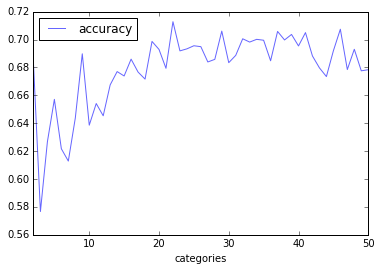

In [14]:
from pandas import DataFrame
res = DataFrame(cuts, columns=['accuracy', 'categories'])
import numpy as np

alpha = 0.6

res = res.set_index('categories')
res.plot(kind='line', label='accuracy', alpha=alpha)
plt.legend(loc='best')

In [15]:
res.loc[res['accuracy'].apply(lambda r: r == res.accuracy.max())]

,accuracy
categories,
22,0.712757


In [16]:
from sklearn.tree import DecisionTreeClassifier

tmodel = DecisionTreeClassifier()
taccs = run_model(tmodel, stocks)
accs = [cm.accuracy for cm in taccs.values()]
accs.sort()
print(sum(accs)/5.)

0.631174282658


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.7084047433345456


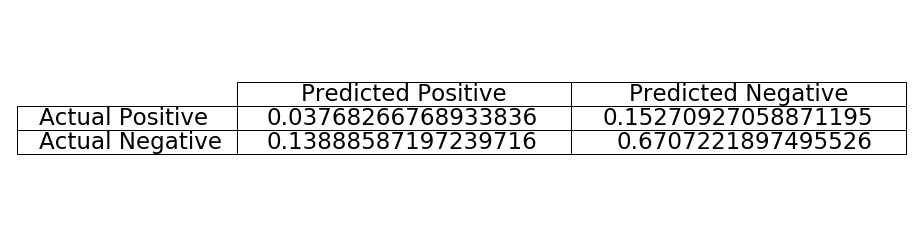

In [21]:
tmodel = DecisionTreeClassifier()
tree_stocks = [(pandas.get_dummies(data.apply(lambda s: pandas.qcut(s.rank(method='first'), 22))), classes) for data, classes in stocks]
cut_accs = run_model(tmodel, tree_stocks)
cm = ConfusionMatrix.concat(iterator=cut_accs.values())
cm.plot()

In [22]:
print(cm.true_acc())

0.21341665826499803


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.6311742826578988


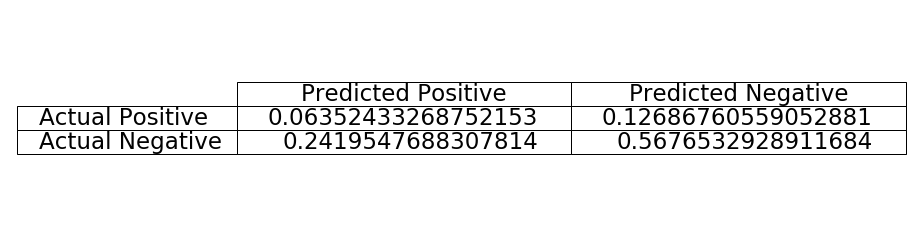

In [19]:
ConfusionMatrix.concat(iterator=taccs.values()).plot()

In [20]:
print(ConfusionMatrix.concat(iterator=taccs.values()).true_acc())

0.2079498478677941


(Not relevant anymore) We got a little less good predictions for positive. This isn't good because it hurts the comparison so we will try to force more positive predictions using weights and see if the accuracy improved.

DecisionTreeClassifier(class_weight={False: 1, True: 1.7}, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.713992871274923


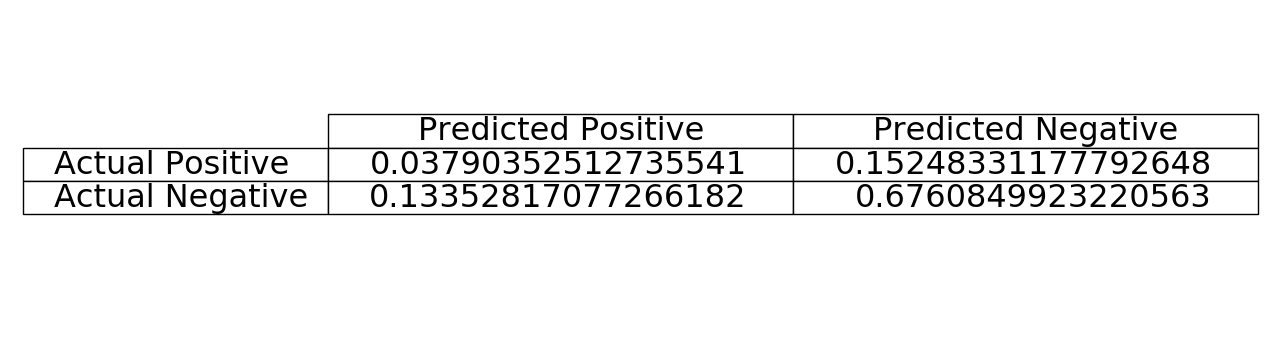

In [43]:
from sklearn.tree import DecisionTreeClassifier
tmodel = DecisionTreeClassifier(class_weight={True:1.7, False:1})
tree_stocks = [(pandas.get_dummies(data.apply(lambda s: pandas.qcut(s.rank(method='first'), 21))), classes) for data, classes in stocks]
cut_accs = run_model(tmodel, tree_stocks)
cm = ConfusionMatrix.concat(iterator=cut_accs.values())
cm.plot()

In [4]:
best_cut=22

In [5]:
from sklearn.tree import DecisionTreeClassifier

# create iterables for all options and use itertools product
# criterion=['gini', 'entropy']
# max_depth=[5, 10, 50]
# using percentages
# min_samples_leaf=[0.005, 0.01, 0.02, 0.05, 0.1]

tree_stocks = [(pandas.get_dummies(data.apply(lambda s: pandas.qcut(s.rank(method='first'), best_cut))), classes) for data, classes in stocks]

# tmodels = [DecisionTreeClassifier(criterion=c, max_depth=md, min_samples_leaf=msl) for c, md, msl in product(criterion, max_depth, min_samples_leaf)]

In [6]:
def run_model_t(model):
    return run_model(model, tree_stocks)

In [7]:
from pandas import DataFrame

def get_results(models):
    accuracies = list(map(run_model_t, models))
    # data should be list of lists and each row should be:
    # criterion, max_depth, min_samples, stock, accuracy
    data = []
    for tmodel, taccs in zip(models, accuracies):
        for tsn, cm in taccs.items():
            data.append((tmodel.criterion, tmodel.max_depth, tmodel.min_samples_leaf, tsn, cm.accuracy, cm.true_acc(), cm.false_acc(), cm.TruePos))
    results = DataFrame(data, columns=('criterion', 'max_depth', 'min_samples', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))
    return results

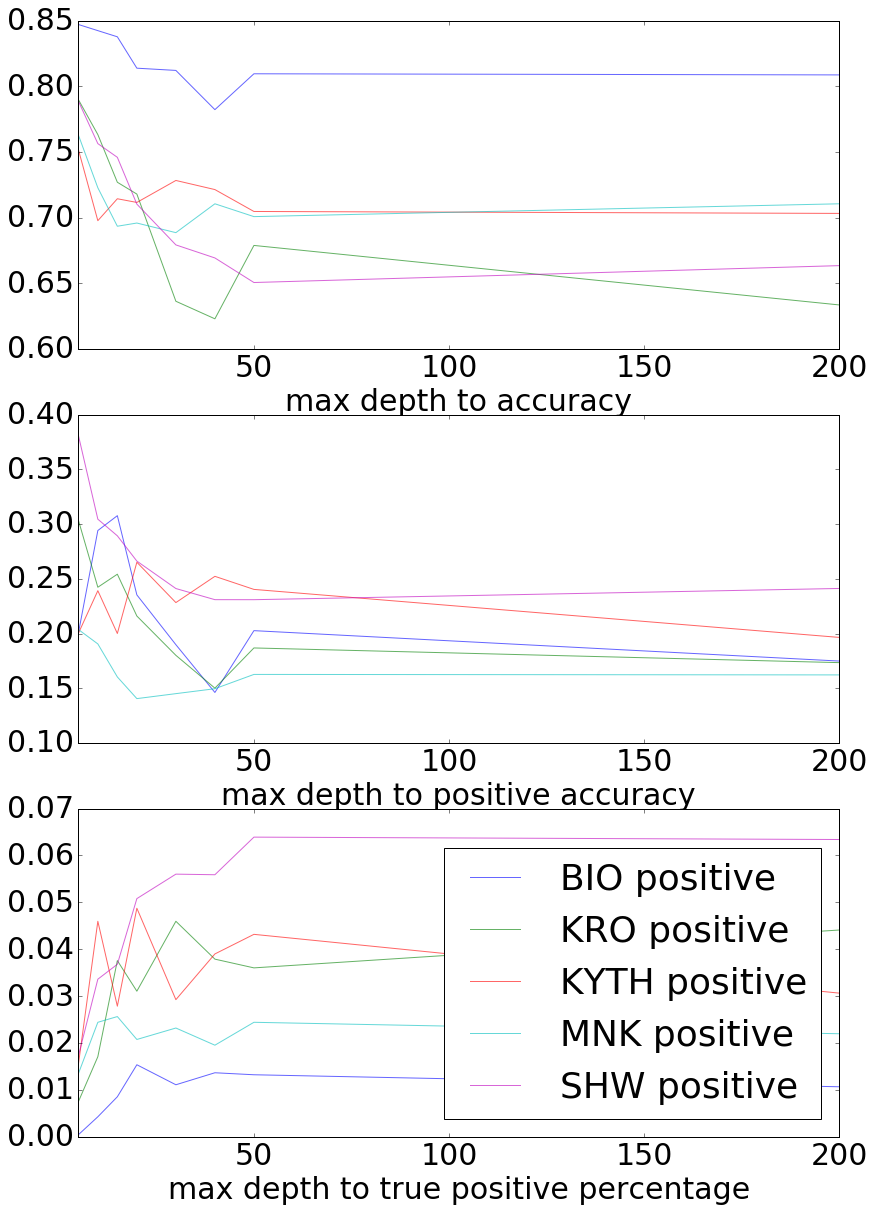

In [54]:
import numpy as np

%matplotlib inline

depths = [5, 10, 15, 20, 30, 40, 50, None]
models = [DecisionTreeClassifier(max_depth=d) for d in depths]
results = get_results(models)

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 200).groupby('max_depth').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('max depth to accuracy')

ax2 = plt.subplot2grid((3,2), (1,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 200).groupby('max_depth').agg('mean')['positive acc'].plot(kind='line', label=name+' positive', alpha=alpha)
ax2.set_xlabel('max depth to positive accuracy')

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 200).groupby('max_depth').agg('mean')['true positive'].plot(kind='line', label=name+' positive', alpha=alpha)
ax3.set_xlabel('max depth to true positive percentage')

plt.legend(loc='best')


In [58]:
min_samples = [1, 2, 5, 10, 15, 20, 30, 40]
models = [DecisionTreeClassifier(min_samples_leaf=m) for m in min_samples]
results = get_results(models)

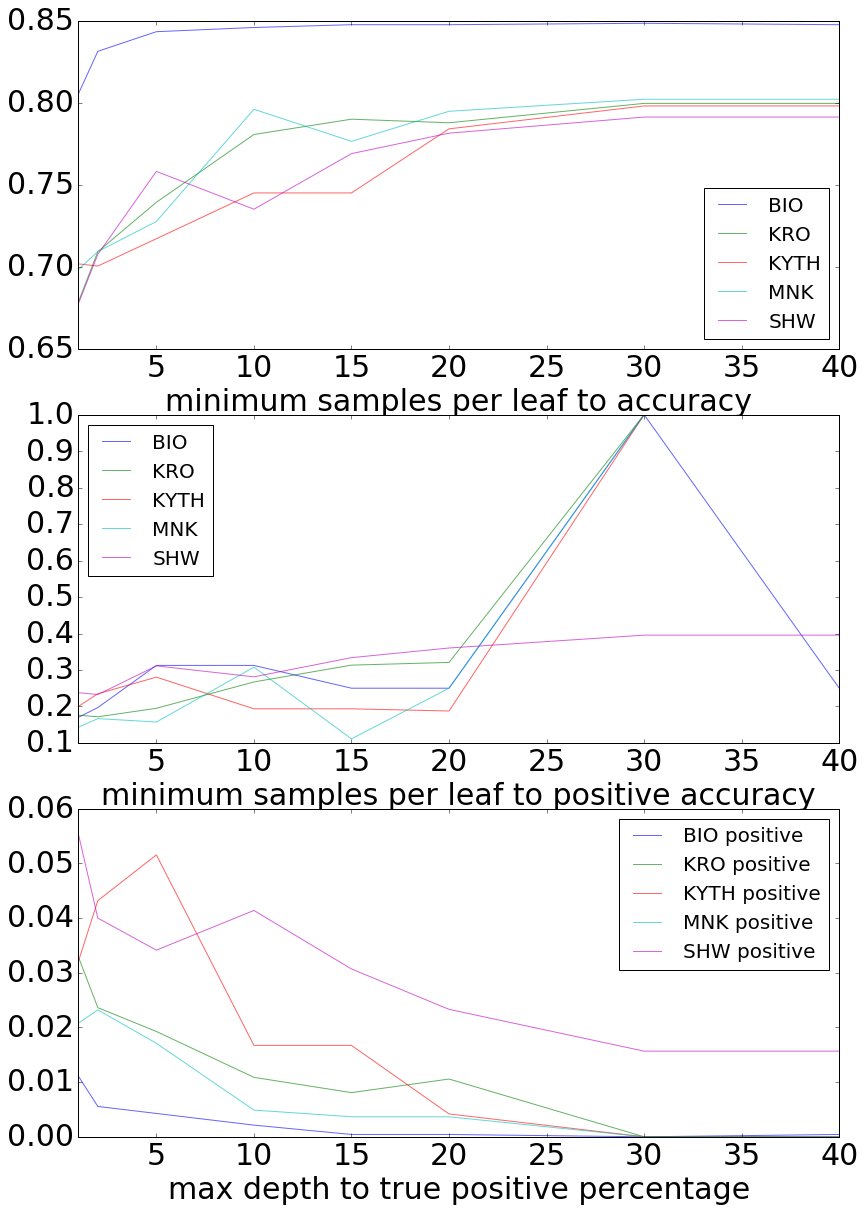

In [57]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('min_samples').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('minimum samples per leaf to accuracy')
plt.legend(loc='best', prop={'size':20})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('min_samples').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('minimum samples per leaf to positive accuracy')
plt.legend(loc='best', prop={'size':20})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 200).groupby('min_samples').agg('mean')['true positive'].plot(kind='line', label=name+' positive', alpha=alpha)
ax3.set_xlabel('max depth to true positive percentage')
plt.legend(loc='best', prop={'size':20})

In [59]:
criterion = ['gini', 'entropy']
models = [DecisionTreeClassifier(criterion=c) for c in criterion]
results = get_results(models)

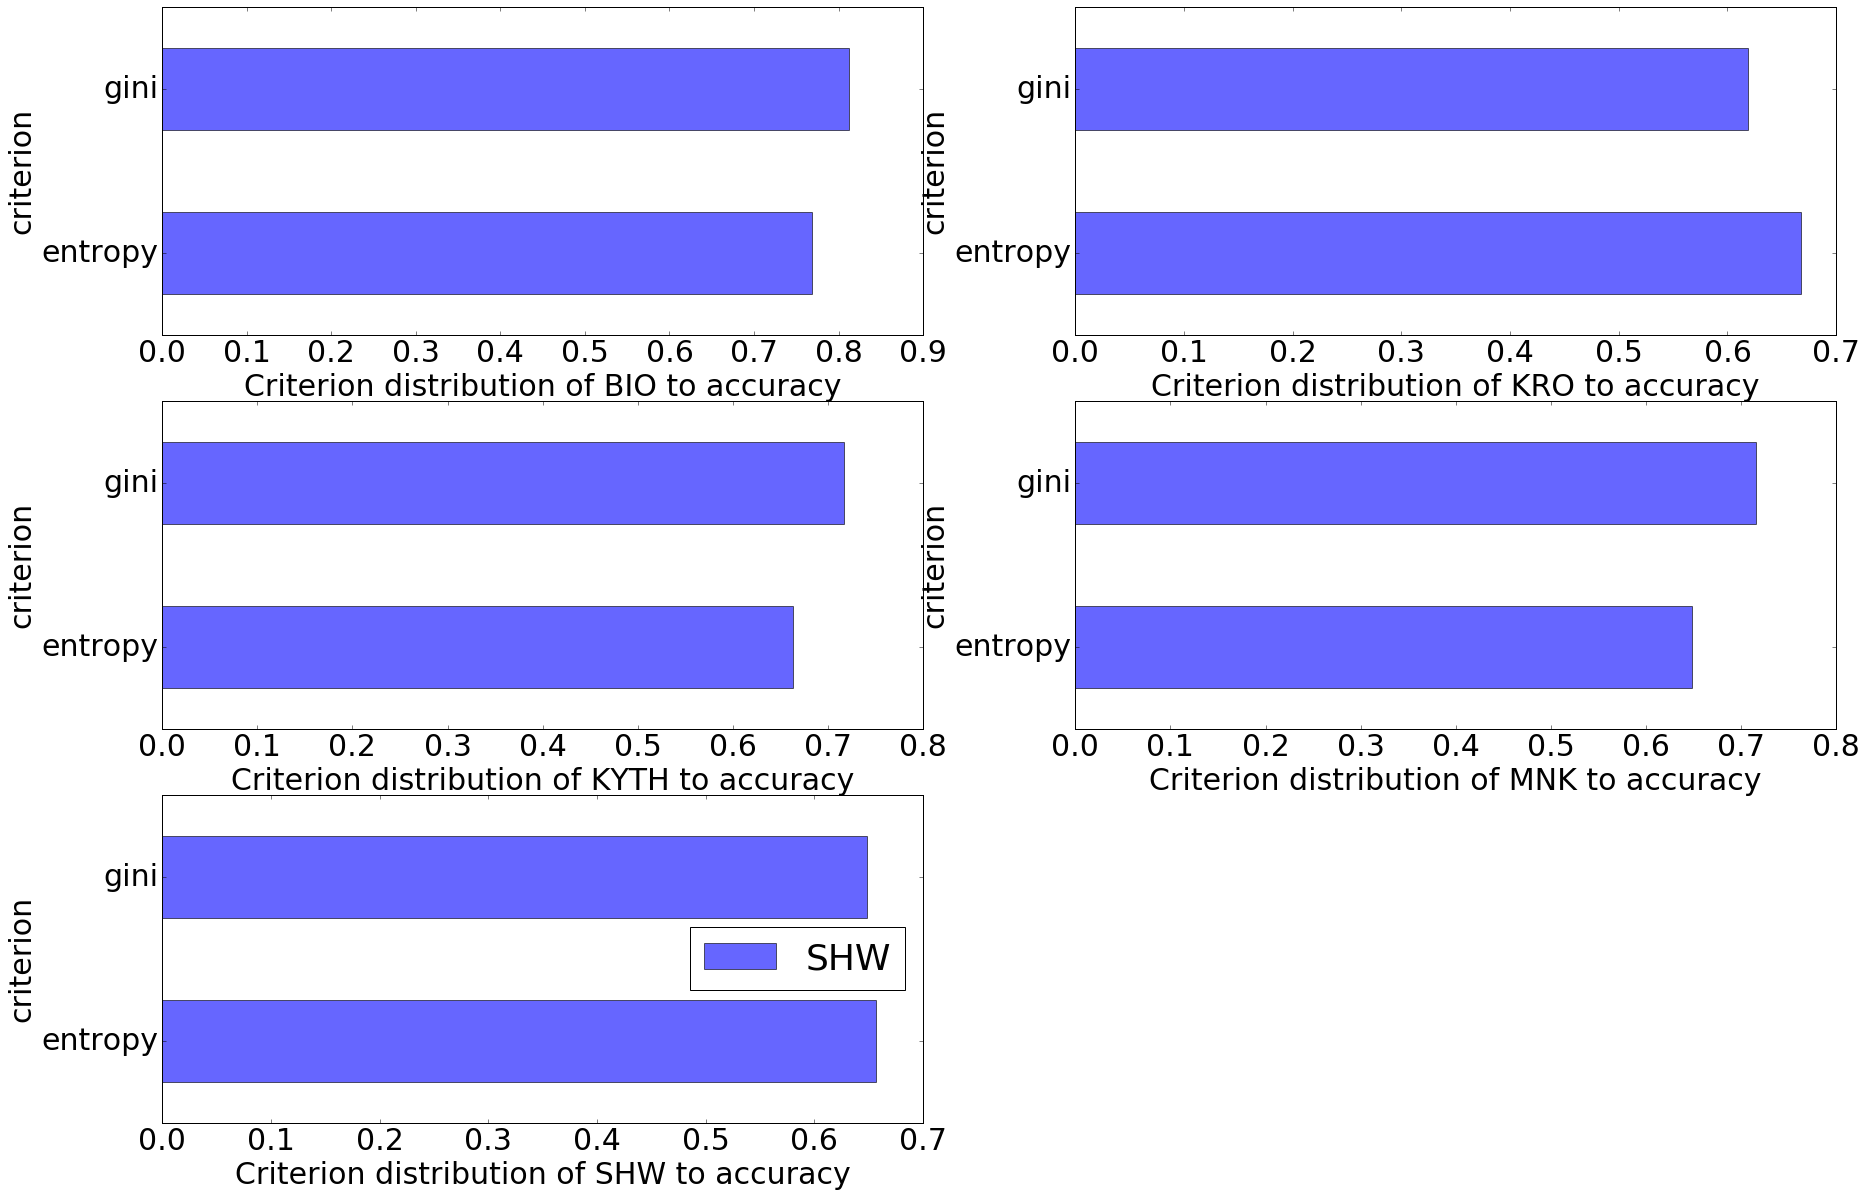

In [60]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(results.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('criterion').agg('mean')['accuracy'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('Criterion distribution of ' + name + ' to accuracy')
plt.legend(loc='best')


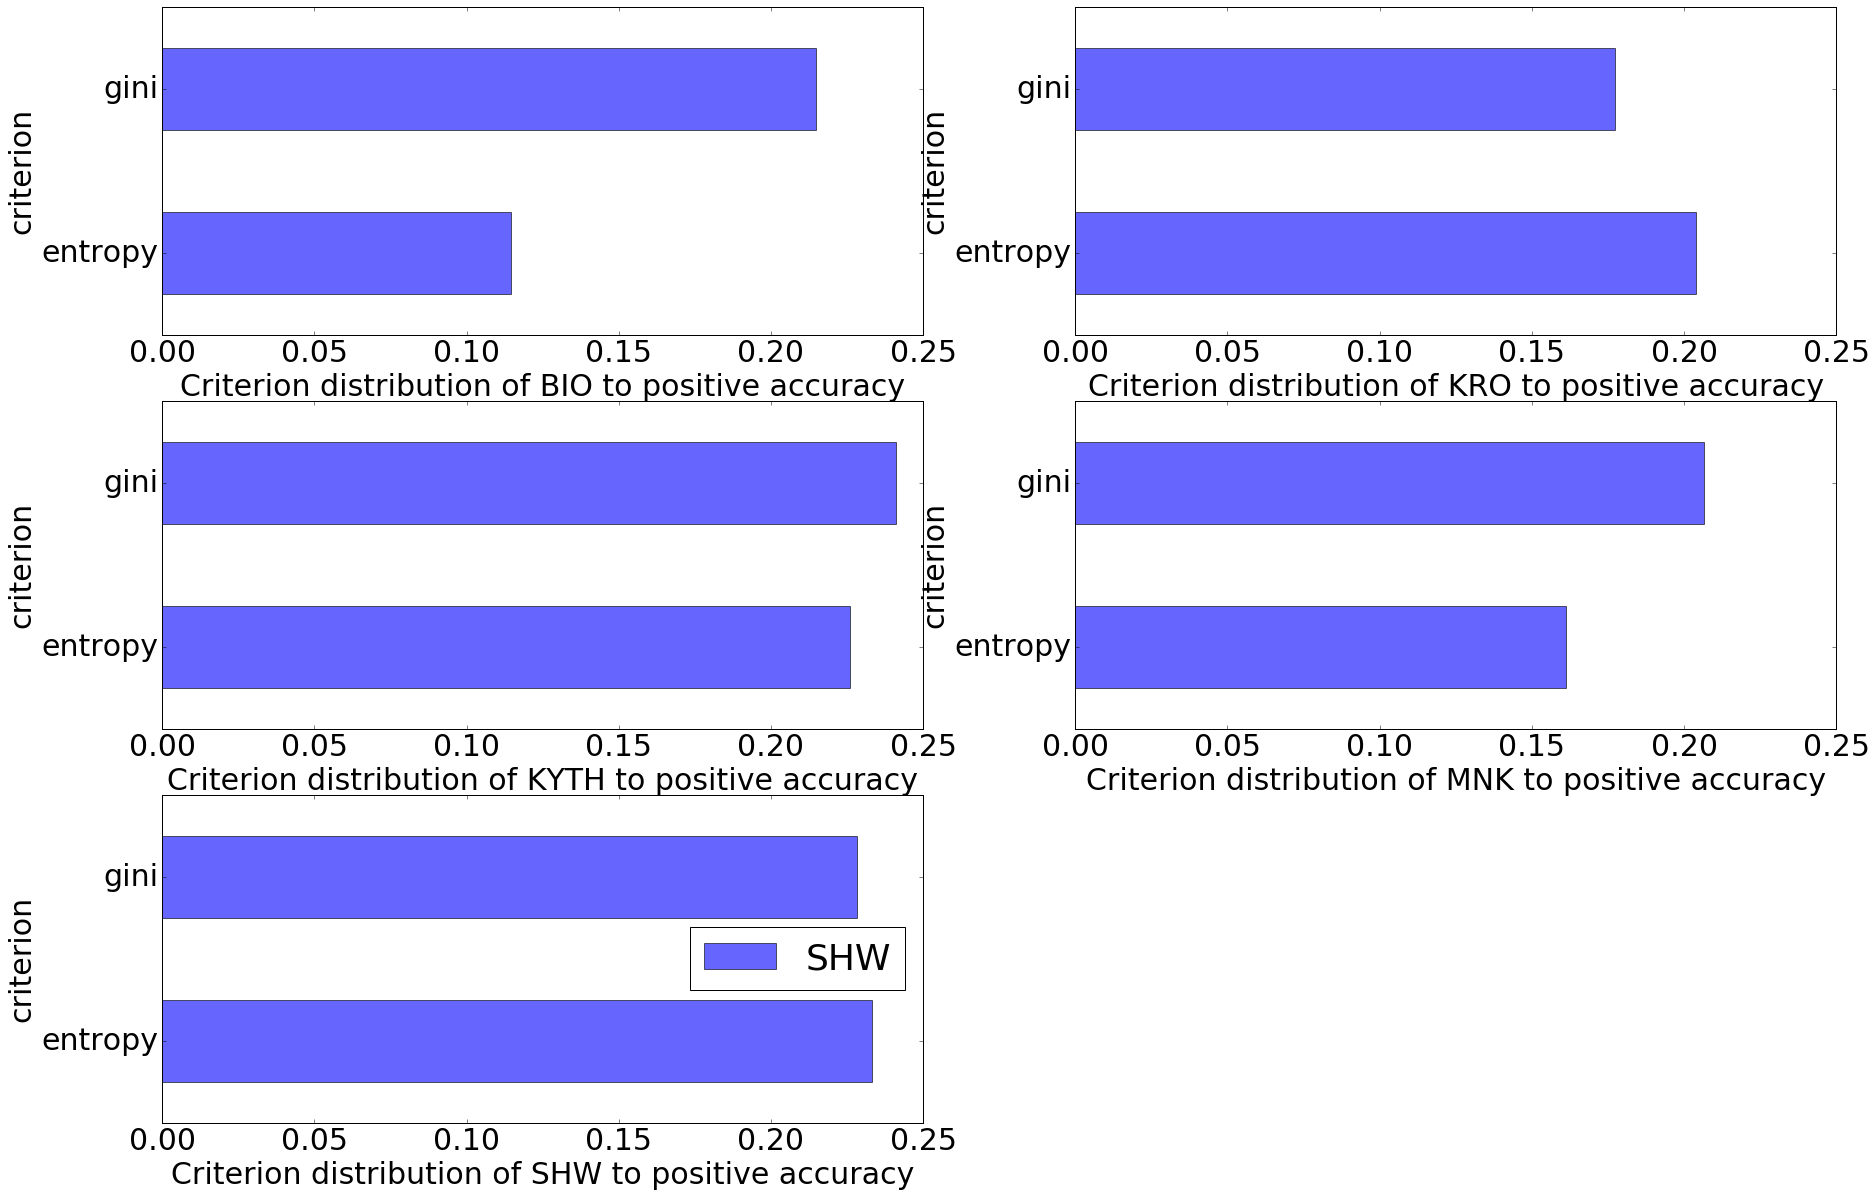

In [61]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(results.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('criterion').agg('mean')['positive acc'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('Criterion distribution of ' + name + ' to positive accuracy')
plt.legend(loc='best')

Too high positive accurac. Want to check negative accuracy for sanity check

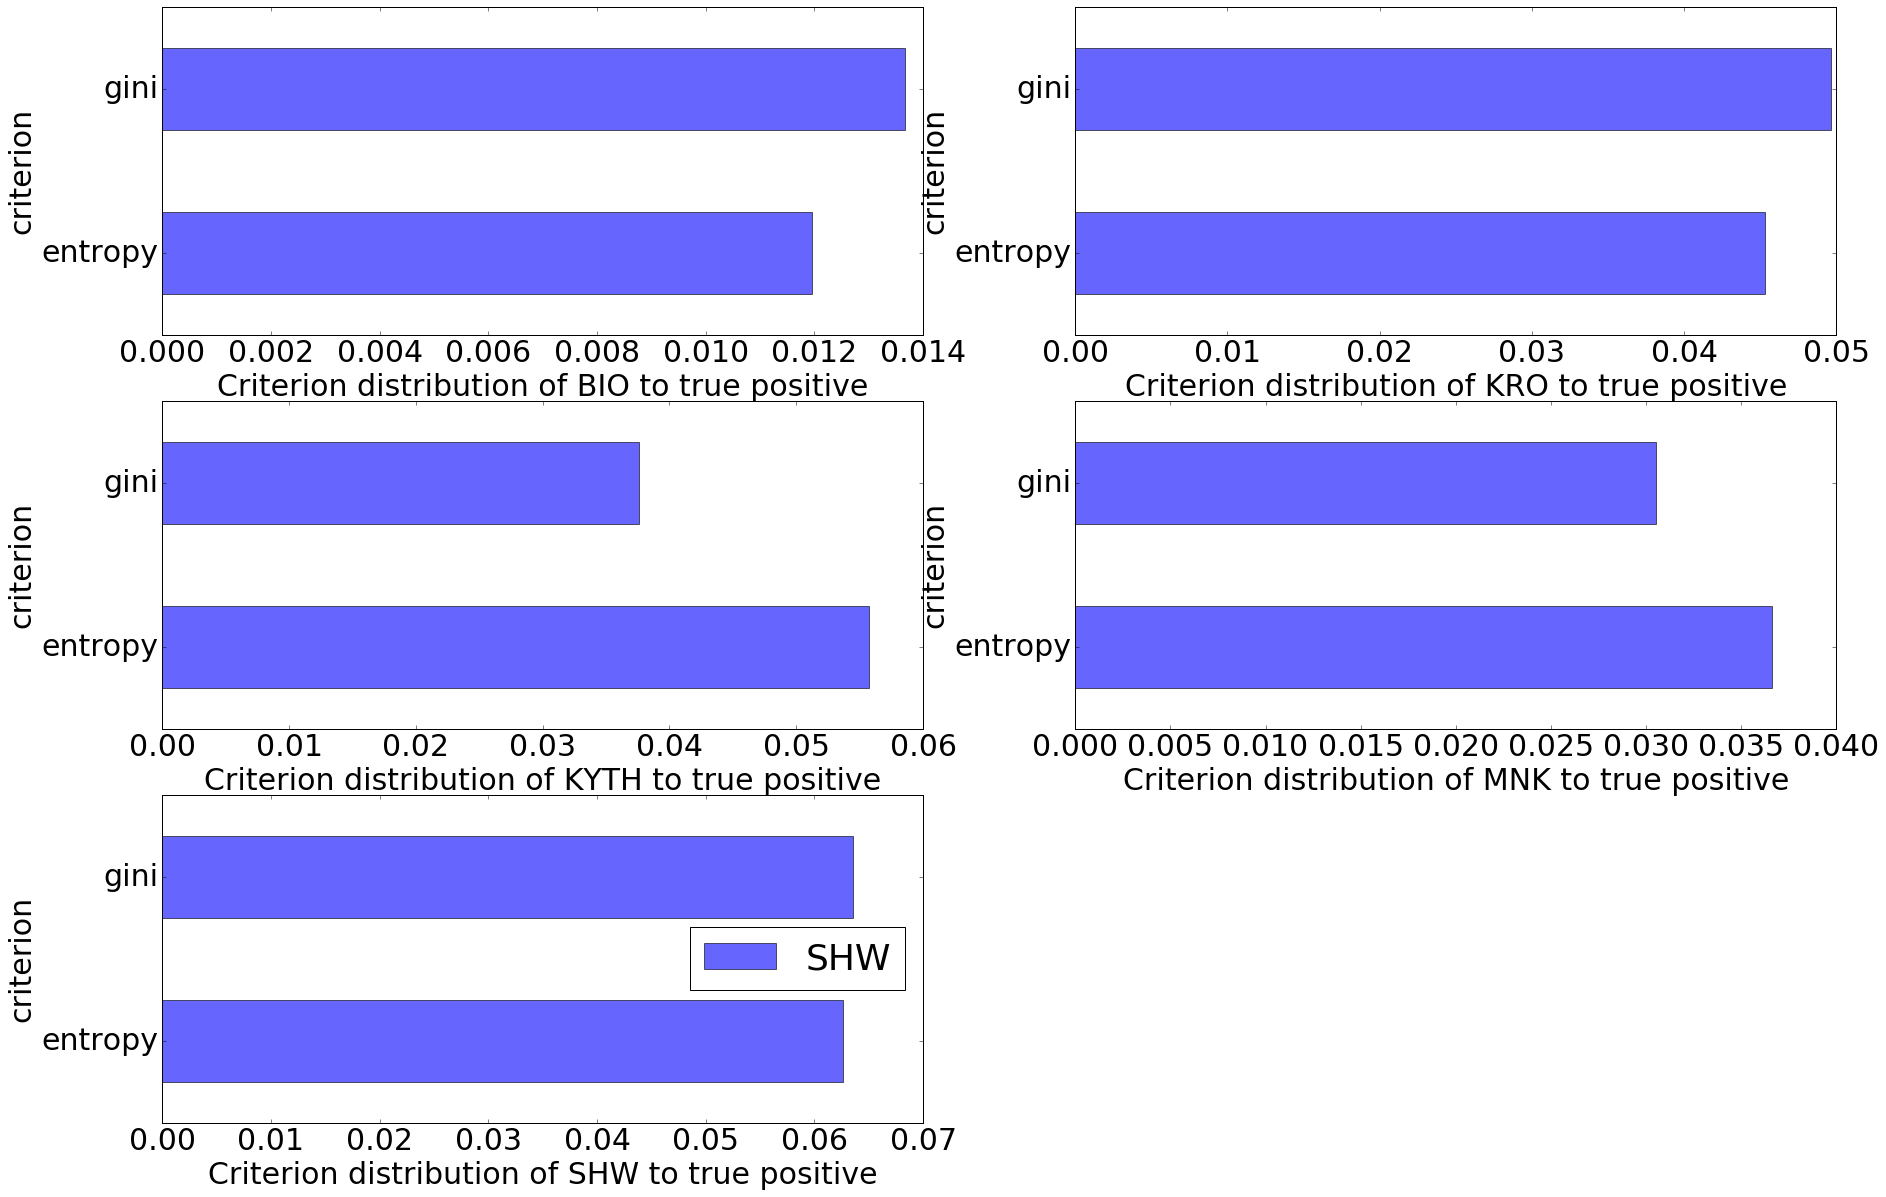

In [62]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(results.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('criterion').agg('mean')['true positive'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('Criterion distribution of ' + name + ' to true positive')
plt.legend(loc='best')

# Variance Reduction
The work will be done with a model chosen from the graphs of the previous sections. In order to save time a "good enough" (meaning one which will show improvment in or final tests) model is used. If we will chose to expand this work we would use F1 score to chose the appropriate model.

We will try 3 approches. 

    1. using standard sklearn feature selection. 
    2. bagging
    3. using relation strength classifier.

In [38]:
import sklearn.tree 
criterion = "gini"
max_depth = 50
minimum_samples_leaf = 5 # maybe try 20 also but prefer lower accuracy for better true accuracy
model = sklearn.tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_leaf=minimum_samples_leaf)
accs = run_model_t(model)

In [11]:
concated_accs = ConfusionMatrix.concat(*list(accs.values()))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.7489502688210805


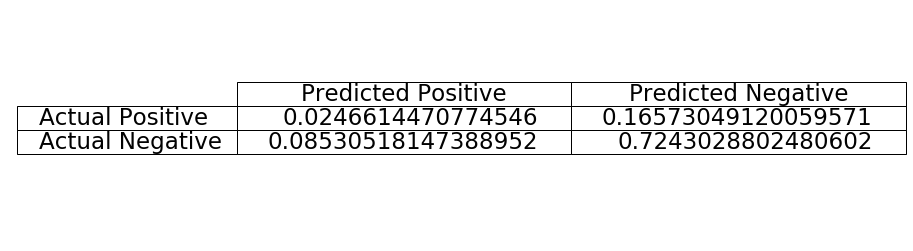

In [12]:
concated_accs.plot()

Looking at the confusion matrix we got results pretty much as expected from previous experiments. 
Now we will try to improve these results

## Standard feature selection

We have plenty of samples so it seems wiser to use mutual_info score func, and trying to remove features by those who have small variance.

In [24]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

results = []
for i in range(5, 50, 10):
    filtered_tree_stocks = [(pandas.DataFrame(SelectKBest(score_func=mutual_info_classif, k=i).fit_transform(data, classes)), pandas.Series(classes)) for data, classes in tree_stocks]
    results.append((i, run_model(model, filtered_tree_stocks)))

In [25]:
temp = results

In [36]:
results = []
for k, acc in temp:
    for tsn, cm in acc.items():
        results.append((k, tsn, cm.accuracy, cm.true_acc(), cm.false_acc(), cm.TruePos))

results = pandas.DataFrame(results, columns=('Kfeatures', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))

/home/eytan/work/Stockifier/Utilities/confusion_matrix.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return self.TruePos / (self.TruePos + self.FalsePos)


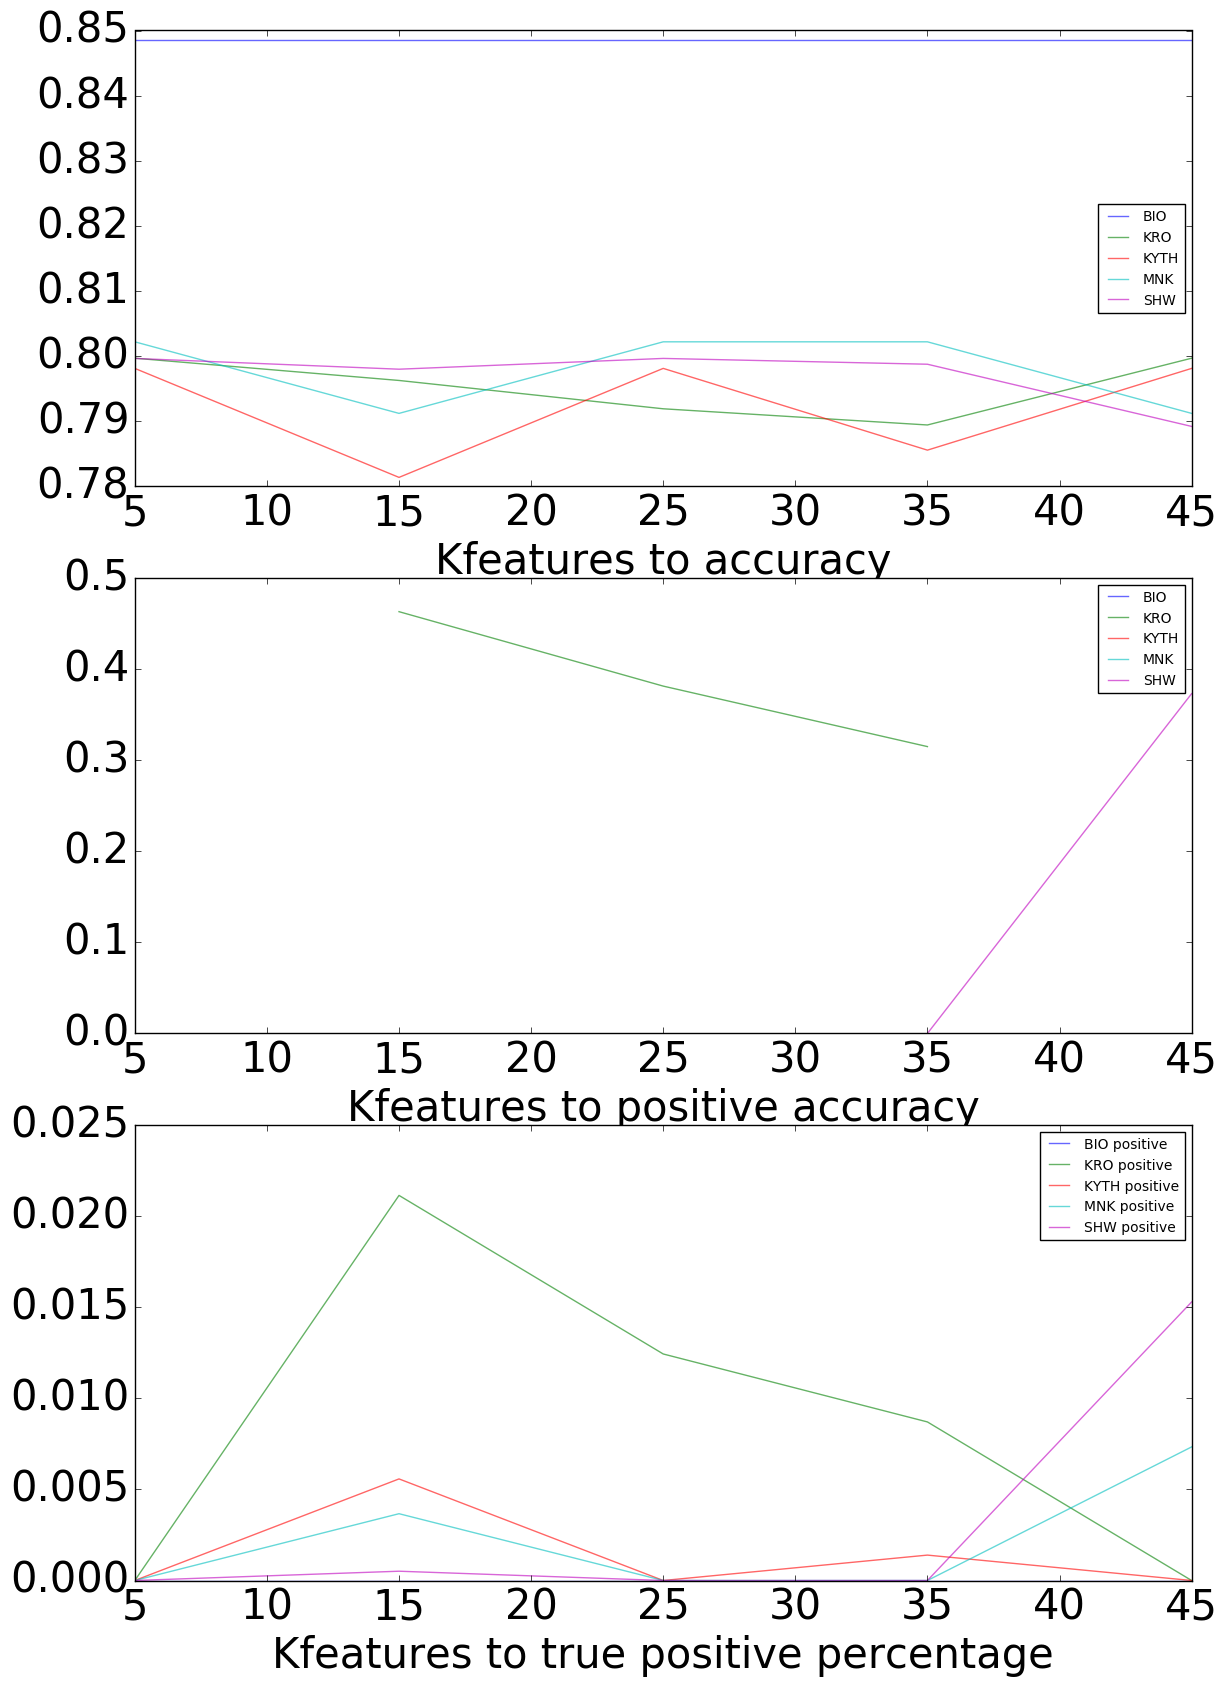

In [37]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('Kfeatures').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('Kfeatures to accuracy')
plt.legend(loc='best', prop={'size':10})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('Kfeatures').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('Kfeatures to positive accuracy')
plt.legend(loc='best', prop={'size':10})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 0).groupby('Kfeatures').agg('mean')['true positive'].plot(kind='line', label=name+' positive', alpha=alpha)
ax3.set_xlabel('Kfeatures to true positive percentage')
plt.legend(loc='best', prop={'size':10})

In [28]:
big_results = []
for i in range(50, 250, 20):
    big_filtered_tree_stocks = [(pandas.DataFrame(SelectKBest(score_func=mutual_info_classif, k=i).fit_transform(data, classes)), pandas.Series(classes)) for data, classes in tree_stocks]
    big_results.append((i, run_model(model, big_filtered_tree_stocks)))

In [29]:
big_temp = big_results

In [32]:
big_results = []
for k, acc in big_temp:
    for tsn, cm in acc.items():
        big_results.append((k, tsn, cm.accuracy, cm.true_acc(), cm.false_acc(), cm.TruePos))

results = pandas.DataFrame(big_results, columns=('Kfeatures', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))

/home/eytan/work/Stockifier/Utilities/confusion_matrix.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return self.TruePos / (self.TruePos + self.FalsePos)


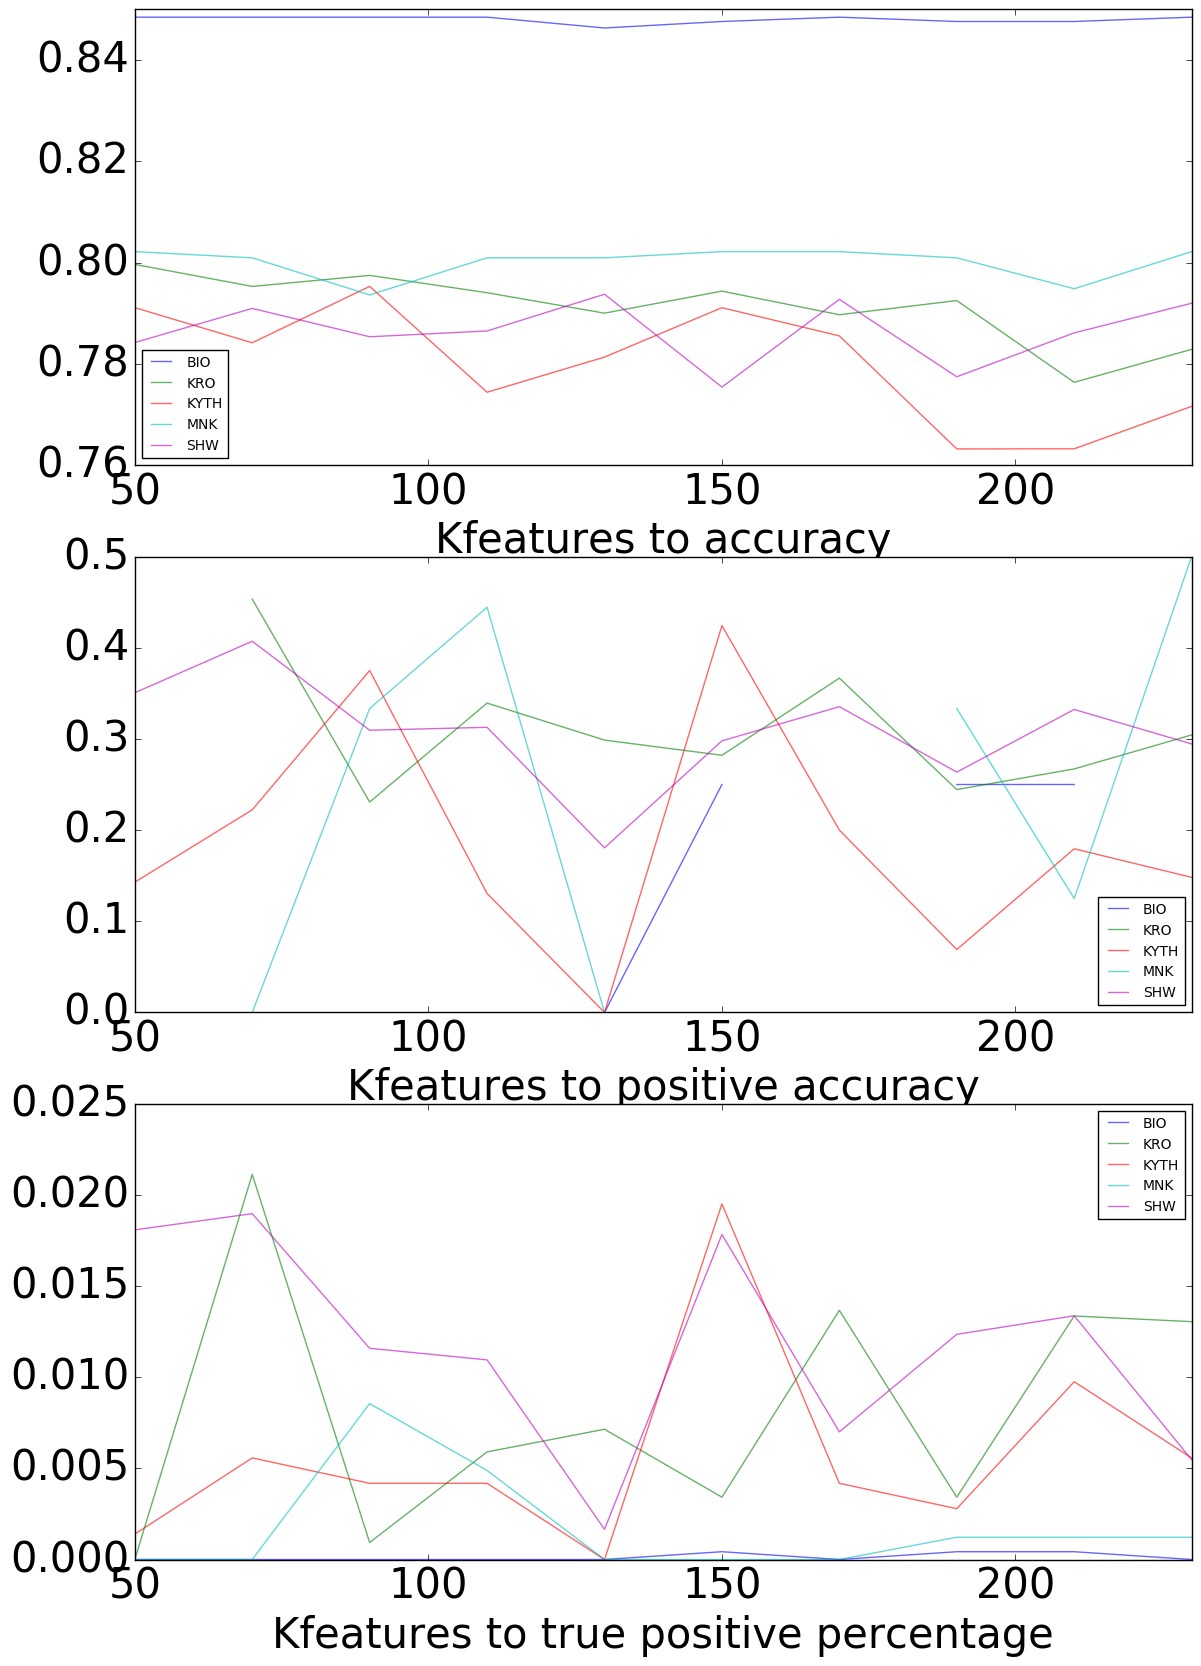

In [35]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('Kfeatures').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('Kfeatures to accuracy')
plt.legend(loc='best', prop={'size':10})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('Kfeatures').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('Kfeatures to positive accuracy')
plt.legend(loc='best', prop={'size':10})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 0).groupby('Kfeatures').agg('mean')['true positive'].plot(kind='line', label=name, alpha=alpha)
ax3.set_xlabel('Kfeatures to true positive percentage')
plt.legend(loc='best', prop={'size':10})

In [38]:
from sklearn.feature_selection import VarianceThreshold

variance_threshold_results = []
for i in range(1, 11):
    try:
        thresh = float(i)/100
        filtered_tree_stocks = [(pandas.DataFrame(VarianceThreshold(threshold=thresh).fit_transform(data, classes)), 
                                 pandas.Series(classes)) for data, classes in tree_stocks]
        variance_threshold_results.append((thresh, run_model(model, filtered_tree_stocks)))
    except Exception as e:
        print('Skipping threshold {} as it doesnt have enough variance: {}'.format(float(i)/100, str(e)))

Skipping threshold 0.05 as it doesnt have enough variance: No feature in X meets the variance threshold 0.05000
Skipping threshold 0.06 as it doesnt have enough variance: No feature in X meets the variance threshold 0.06000
Skipping threshold 0.07 as it doesnt have enough variance: No feature in X meets the variance threshold 0.07000
Skipping threshold 0.08 as it doesnt have enough variance: No feature in X meets the variance threshold 0.08000
Skipping threshold 0.09 as it doesnt have enough variance: No feature in X meets the variance threshold 0.09000
Skipping threshold 0.1 as it doesnt have enough variance: No feature in X meets the variance threshold 0.10000


In [39]:
variance_threshold_temp = variance_threshold_results

In [42]:
variance_threshold_results = []
for t, acc in variance_threshold_temp:
    for tsn, cm in acc.items():
        variance_threshold_results.append((t, tsn, cm.accuracy, cm.true_acc(), cm.false_acc(), cm.TruePos))

results = pandas.DataFrame(variance_threshold_results, columns=('VThreshold', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))

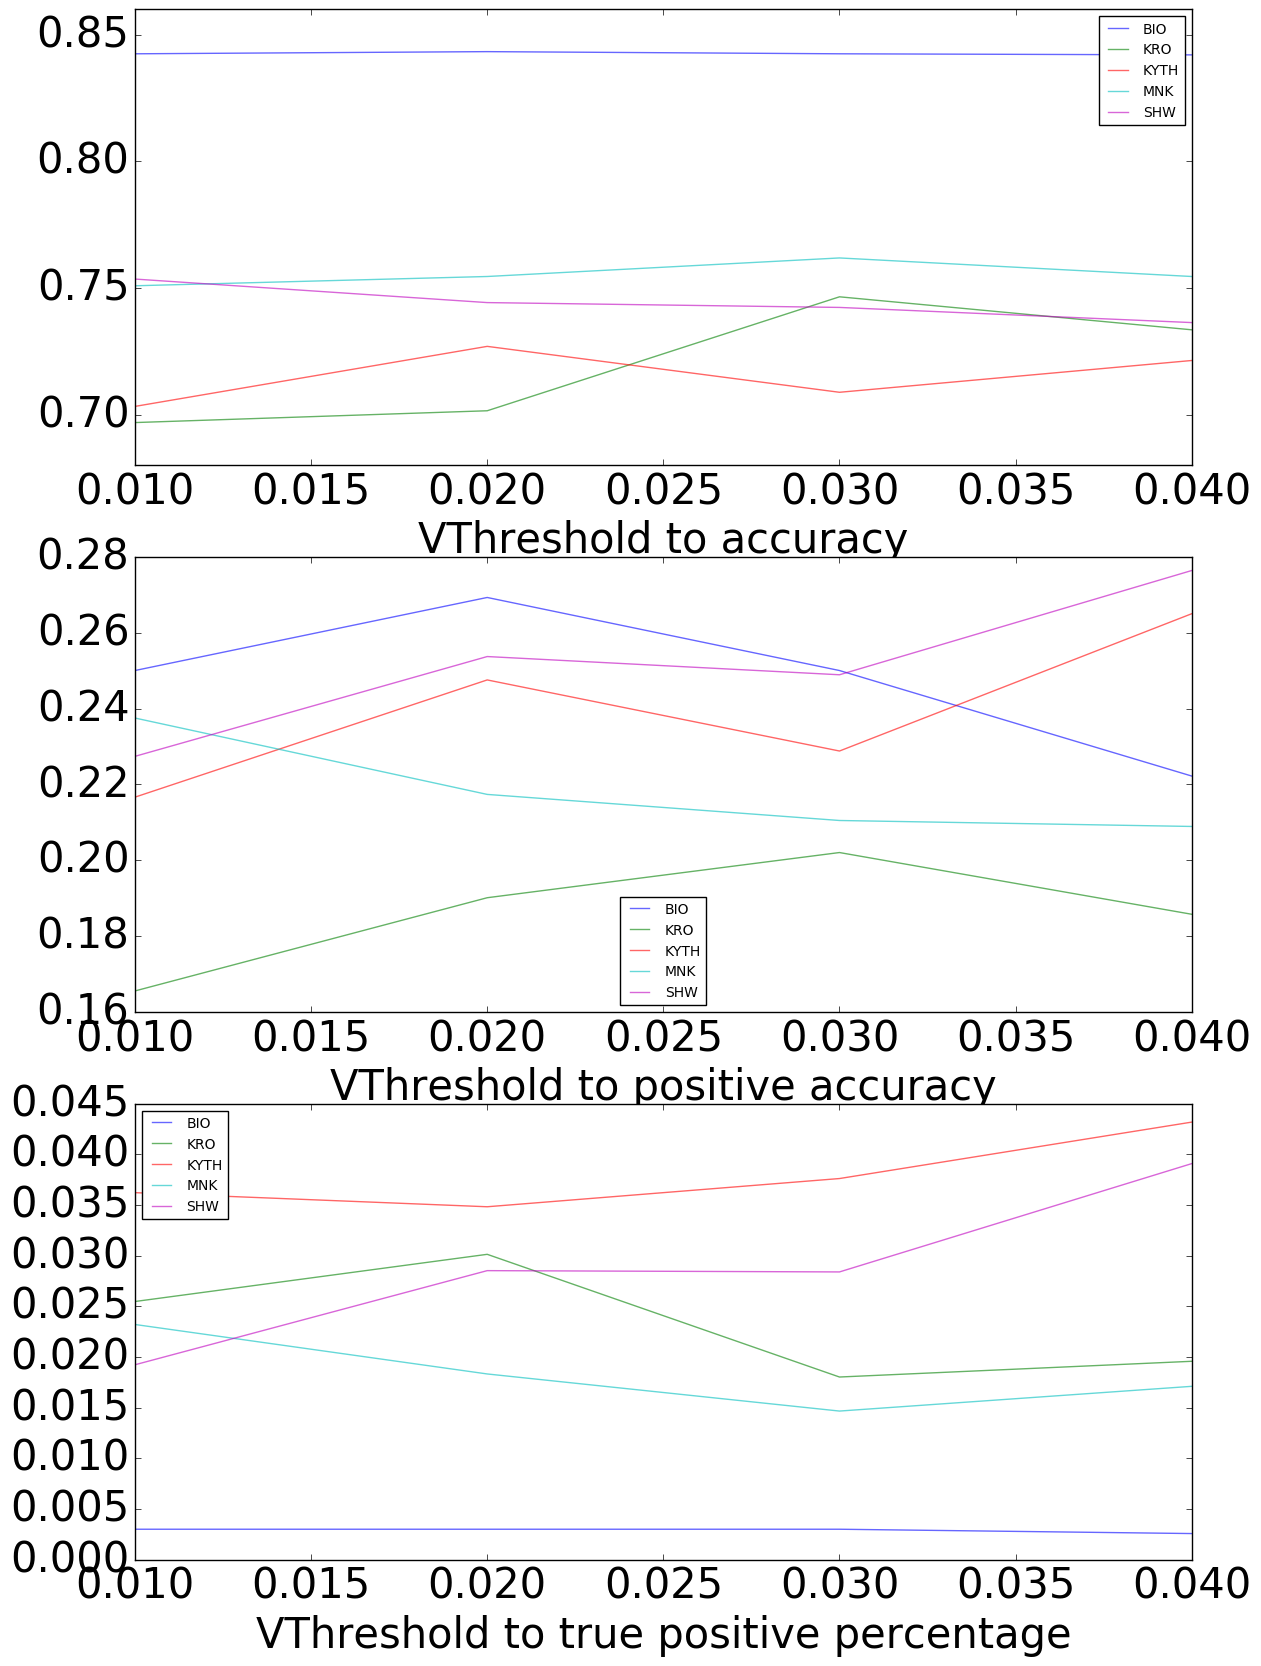

In [43]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('VThreshold').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('VThreshold to accuracy')
plt.legend(loc='best', prop={'size':10})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('VThreshold').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('VThreshold to positive accuracy')
plt.legend(loc='best', prop={'size':10})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 0).groupby('VThreshold').agg('mean')['true positive'].plot(kind='line', label=name, alpha=alpha)
ax3.set_xlabel('VThreshold to true positive percentage')
plt.legend(loc='best', prop={'size':10})

## Connection Strength Classifier

In [9]:
from Utilities.clustering import StrengthCalc

sc = StrengthCalc()

In [10]:
from Classifiers.classifiers import ConnectionStrengthClassifier

# dictionary of market name to strength
stock_strengths = [sc.get_strength_stock(sn, 5, 325, 2, 0.1) for sn in stock_names]

clf = ConnectionStrengthClassifier()

In [11]:
from Utilities import clean_market_name

cols = []
for d, c in tree_stocks:
    cols.extend(d.columns)
all_cols = set(cols)

strengths = []
connections_cols = []
for i, sn in enumerate(stock_names):
    cur_cols = []
    cur_strengths = []
    for m in ld.get_market_names():
        cur_cols.append(list(filter(lambda c: clean_market_name(m) in c, all_cols)))
        cur_strengths.append(stock_strengths[i][m])
    connections_cols.append(cur_cols)
    strengths.append(cur_strengths)

In [12]:
def run_strength_model(model, stocks=tree_stocks, strength=strengths, cols=connections_cols):
    scores = {sn: [] for sn in stock_names}
    for sn, (data, classes), st, cs in zip(stock_names, stocks, strength, cols):
        scores[sn] = ConfusionMatrix((data, classes), model, st, cs) 
    return scores

In [13]:
import Classifiers.classifiers
import sklearn.tree

con_model = Classifiers.classifiers.ConnectionStrengthClassifier(base_estimator=model)
st_accuracies = run_strength_model(con_model, tree_stocks)

In [ ]:
import Classifiers
import sklearn
from itertools import product

thresholds = [0.001, 0.05, 0.1, 0.15]
combined_weights = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
base_strength = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# t_models = [Classifiers.classifiers.ConnectionStrengthClassifier(threshold=t, base_estimator=model) for t in thresholds]
# c_models = [Classifiers.classifiers.ConnectionStrengthClassifier(combined_weight=c, base_estimator=model) for c in combined_weights]
# b_models = [Classifiers.classifiers.ConnectionStrengthClassifier(base_strength=b, base_estimator=model) for b in base_strength]
sct_models = [Classifiers.classifiers.ConnectionStrengthClassifier(threshold=t, base_strength=bs, combined_weight=w, 
                                                                   base_estimator=model) 
          for t, w, bs in product(thresholds, combined_weights, base_strength)]

In [ ]:
# t_accuracies = list(map(run_strength_model, t_models))
# c_accuracies = list(map(run_strength_model, c_models))
# b_accuracies = list(map(run_strength_model, b_models))
sct_accuracies = list(map(run_strength_model, sct_models))

## Analyze strength classifier results

In [19]:
def get_connection_results(models=sct_models, accuracies=sct_accuracies):
    if accuracies is None:
        accuracies = list(map(run_strength_model, models))
    # data should be list of lists and each row should be:
    # criterion, max_depth, min_samples, stock, accuracy
    data = []
    for tmodel, taccs in zip(models, accuracies):
        for tsn, cm in taccs.items():
            data.append((tmodel.threshold, tmodel.combined_weight, tmodel.base_strength, tsn, cm.accuracy, cm.true_acc(), cm.false_acc(), cm.TruePos))
    results = DataFrame(data, columns=('threshold', 'combined_weight', 'base_strength', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))
    return results

In [20]:
results = get_connection_results()

/home/eytan/work/Stockifier/Utilities/confusion_matrix.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return self.TruePos / (self.TruePos + self.FalsePos)


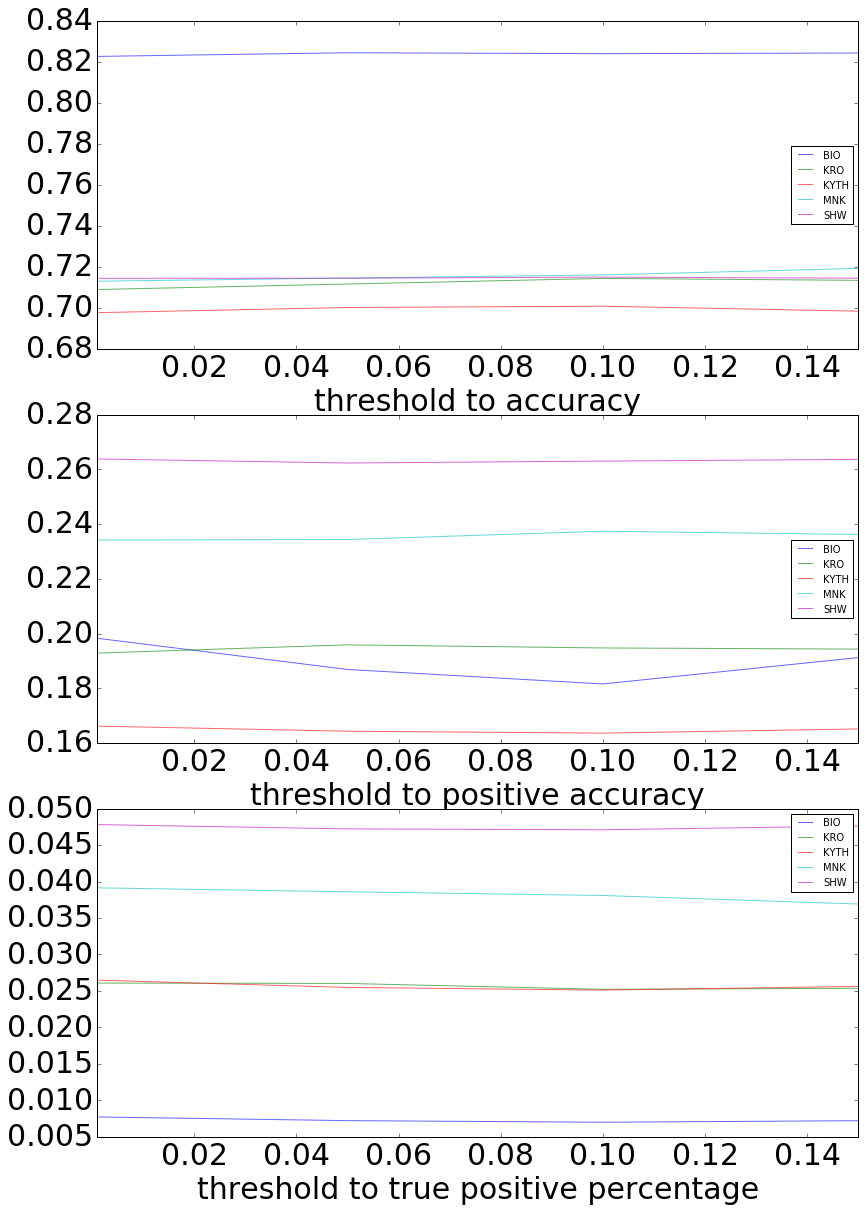

In [21]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('threshold').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('threshold to accuracy')
plt.legend(loc='best', prop={'size':10})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('threshold').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('threshold to positive accuracy')
plt.legend(loc='best', prop={'size':10})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 0).groupby('threshold').agg('mean')['true positive'].plot(kind='line', label=name, alpha=alpha)
ax3.set_xlabel('threshold to true positive percentage')
plt.legend(loc='best', prop={'size':10})

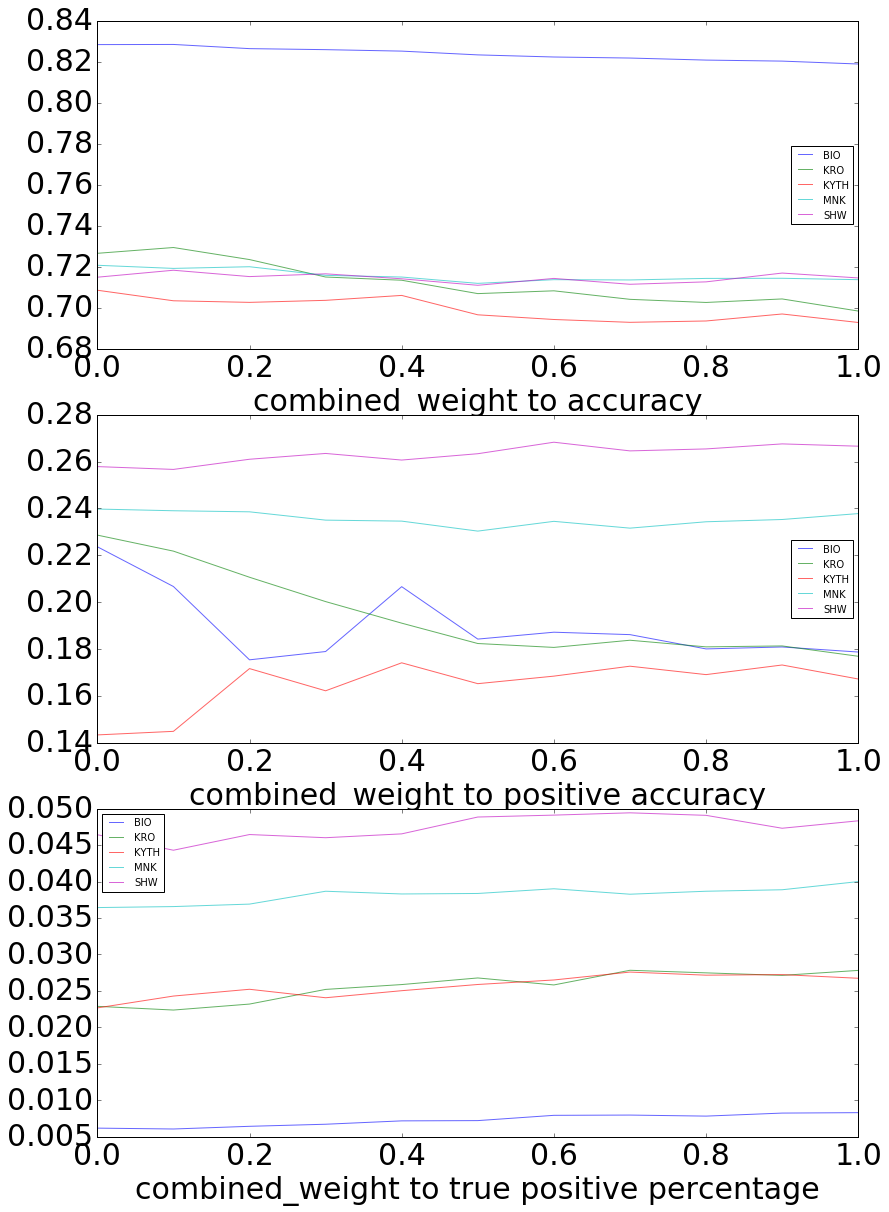

In [22]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('combined_weight').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('combined_weight to accuracy')
plt.legend(loc='best', prop={'size':10})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('combined_weight').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('combined_weight to positive accuracy')
plt.legend(loc='best', prop={'size':10})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 0).groupby('combined_weight').agg('mean')['true positive'].plot(kind='line', label=name, alpha=alpha)
ax3.set_xlabel('combined_weight to true positive percentage')
plt.legend(loc='best', prop={'size':10})

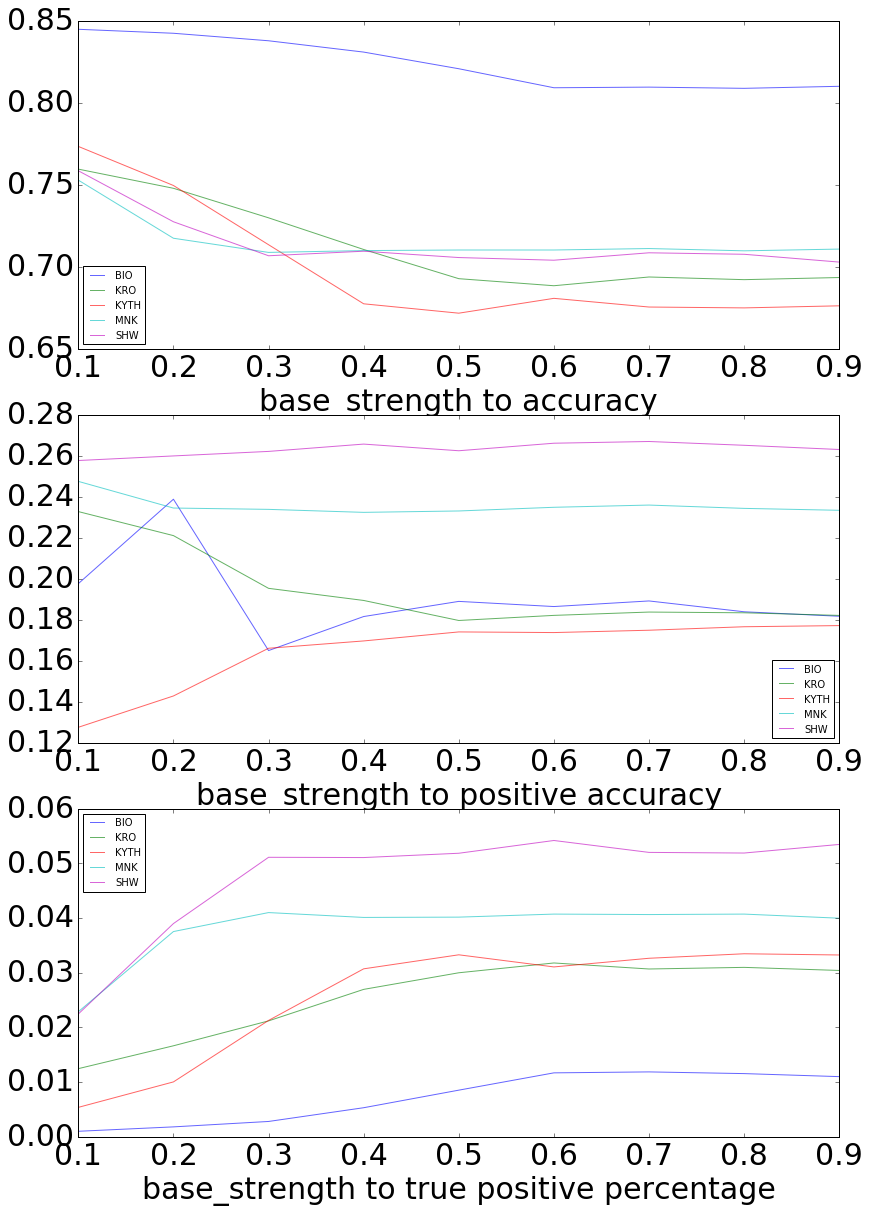

In [23]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('base_strength').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('base_strength to accuracy')
plt.legend(loc='best', prop={'size':10})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('base_strength').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('base_strength to positive accuracy')
plt.legend(loc='best', prop={'size':10})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 0).groupby('base_strength').agg('mean')['true positive'].plot(kind='line', label=name, alpha=alpha)
ax3.set_xlabel('base_strength to true positive percentage')
plt.legend(loc='best', prop={'size':10})

In [33]:
aggr = results.groupby(['threshold', 'base_strength', 'combined_weight']).agg('mean')
aggr.loc[aggr['accuracy'] == aggr['accuracy'].max()]

,,,accuracy,positive acc,negative acc,true positive
threshold,base_strength,combined_weight,,,,
0.1,0.1,0.0,0.802857,0.259873,0.811321,0.005023


In [34]:
aggr.loc[aggr['positive acc'] == aggr['positive acc'].max()]

,,,accuracy,positive acc,negative acc,true positive
threshold,base_strength,combined_weight,,,,
0.001,0.2,0.0,0.770754,0.389228,0.811597,0.015791


In [32]:
aggr.loc[aggr['true positive'] == aggr['true positive'].max()]

,,,accuracy,positive acc,negative acc,true positive
threshold,base_strength,combined_weight,,,,
0.1,0.6,0.2,0.71781,0.220531,0.815947,0.038061


In [58]:
temp = aggr.loc[0.026 > aggr['true positive']]
temp = temp.loc[0.22 < temp['positive acc']]
temp = temp.loc[0.23 > temp['positive acc']]
temp = temp.loc[0.021 < temp['true positive']]
temp

,,,accuracy,positive acc,negative acc,true positive
threshold,base_strength,combined_weight,,,,
0.05,0.2,0.4,0.755084,0.227573,0.812164,0.021608


### Bagging

In [40]:
from sklearn.ensemble import BaggingClassifier
base_estimator = model
n_estimators = [10, 20, 30]
max_samples = [0.5, 0.7, 0.9, 1]
max_features = [0.5, 0.7, 0.9, 1]
n_jobs = 4

bagging_models = [BaggingClassifier(max_samples=s, max_features=f, n_estimators=n, base_estimator=model, n_jobs=n_jobs) 
          for n, s, f in product(n_estimators, max_samples, max_features)]

In [41]:
bagging_accs = list(map(run_model_t, bagging_models))

In [59]:
def get_bagging_results(models=bagging_models, accuracies=bagging_accs):
    if accuracies is None:
        accuracies = list(map(run_model_t, models))
    # data should be list of lists and each row should be:
    # criterion, max_depth, min_samples, stock, accuracy
    data = []
    for tmodel, taccs in zip(models, accuracies):
        for tsn, cm in taccs.items():
            data.append((tmodel.max_samples, tmodel.max_features, tmodel.n_estimators, tsn, cm.accuracy, cm.true_acc(), cm.false_acc(), cm.TruePos))
    results = DataFrame(data, columns=('max_samples', 'max_features', 'n_estimators', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))
    return results

In [60]:
results = get_bagging_results()

/home/eytan/work/Stockifier/Utilities/confusion_matrix.py:63: RuntimeWarning: invalid value encountered in double_scalars
  return self.TruePos / (self.TruePos + self.FalsePos)


In [61]:
aggr = results.groupby(['max_samples', 'max_features', 'n_estimators']).agg('mean')
aggr.loc[aggr['accuracy'] == aggr['accuracy'].max()]

accuracy  positive acc  negative acc  \
max_samples max_features n_estimators                                         
0.5         1.0          10             0.80962           NaN      0.809608   
                         20             0.80962           NaN      0.809608   
                         30             0.80962           NaN      0.809608   
0.7         1.0          10             0.80962           NaN      0.809608   
                         20             0.80962           NaN      0.809608   
                         30             0.80962           NaN      0.809608   
0.9         1.0          10             0.80962           NaN      0.809608   
                         20             0.80962           NaN      0.809608   
                         30             0.80962           NaN      0.809608   
1.0         0.5          10             0.80962           NaN      0.809608   
                         20             0.80962           NaN      0.809608   
                         30             0.80962           NaN      0.809608   
            0.7          10             0.80962           NaN      0.809608   
                         20             0.80962           NaN      0.809608   
                         30             0.80962           NaN      0.809608   
            0.9          10             0.80962           NaN      0.809608   
                         20             0.80962           NaN      0.809608   
                         30             0.80962           NaN      0.809608   
            1.0          10             0.80962           NaN      0.809608   
                         20             0.80962           NaN      0.809608   
                         30             0.80962           NaN      0.809608   

                                       true positive  
max_samples max_features n_estimators                 
0.5         1.0          10                      0.0  
                         20                      0.0  
                         30                      0.0  
0.7         1.0          10                      0.0  
                         20                      0.0  
                         30                      0.0  
0.9         1.0          10                      0.0  
                         20                      0.0  
                         30                      0.0  
1.0         0.5          10                      0.0  
                         20                      0.0  
                         30                      0.0  
            0.7          10                      0.0  
                         20                      0.0  
                         30                      0.0  
            0.9          10                      0.0  
                         20                      0.0  
                         30                      0.0  
            1.0          10                      0.0  
                         20                      0.0  
                         30                      0.0

In [62]:
aggr.loc[aggr['positive acc'] == aggr['positive acc'].max()]

,,,accuracy,positive acc,negative acc,true positive
max_samples,max_features,n_estimators,,,,
0.7,0.5,20,0.806424,0.466422,0.810463,0.002486


In [63]:
aggr.loc[aggr['true positive'] == aggr['true positive'].max()]

,,,accuracy,positive acc,negative acc,true positive
max_samples,max_features,n_estimators,,,,
0.7,0.9,10,0.799971,0.237143,0.810289,0.004353


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
adaboost_model = AdaBoostClassifier(base_estimator=model)
final_model = ConnectionStrengthClassifier(base_estimator=adaboost_model, threshold=0.05, base_strength=0.2, combined_weight=0.4)
adaboost_cm = run_strength_model(final_model)

ConnectionStrengthClassifier(base_estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
               base_strength=0.2, combined_weight=0.4, threshold=0.05)
Accuracy: 0.7833570144323148


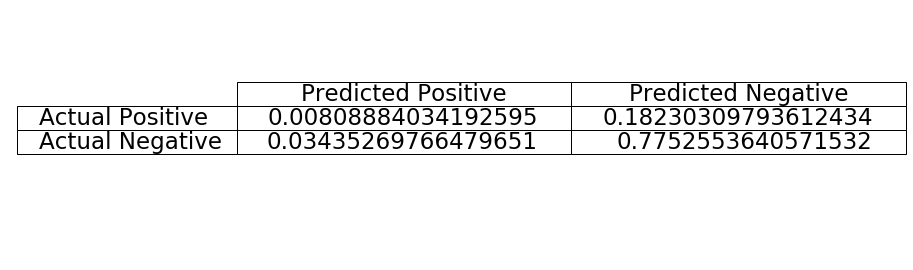

In [71]:
ConfusionMatrix.concat(iterator=adaboost_cm.values()).plot()

In [74]:
final_model2 = ConnectionStrengthClassifier(base_estimator=adaboost_model, threshold=0.001, base_strength=0.2, combined_weight=0.0)
adaboost_cm = run_strength_model(final_model)

ConnectionStrengthClassifier(base_estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
               base_strength=0.2, combined_weight=0.4, threshold=0.05)
Accuracy: 0.7810651766068332


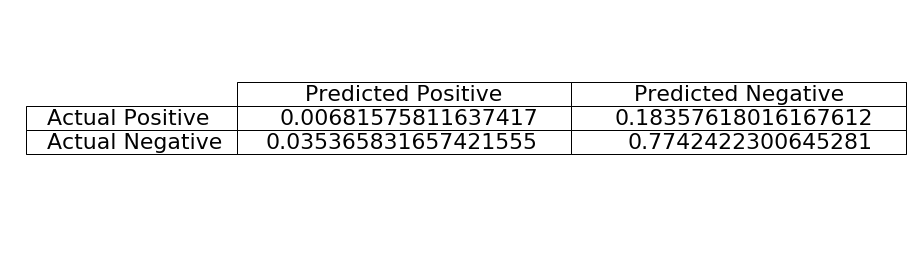

In [75]:
ConfusionMatrix.concat(iterator=adaboost_cm.values()).plot()

In [80]:
model = sklearn.tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_leaf=minimum_samples_leaf, class_weight={False:1, True: 4})
adaboost_model = AdaBoostClassifier(base_estimator=model)
final_model = ConnectionStrengthClassifier(base_estimator=adaboost_model, threshold=0.05, base_strength=0.2, combined_weight=0.4)
adaboost_cm = run_strength_model(final_model)

ConnectionStrengthClassifier(base_estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight={False: 1, True: 4}, criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
               base_strength=0.2, combined_weight=0.4, threshold=0.05)
Accuracy: 0.7845287328551545


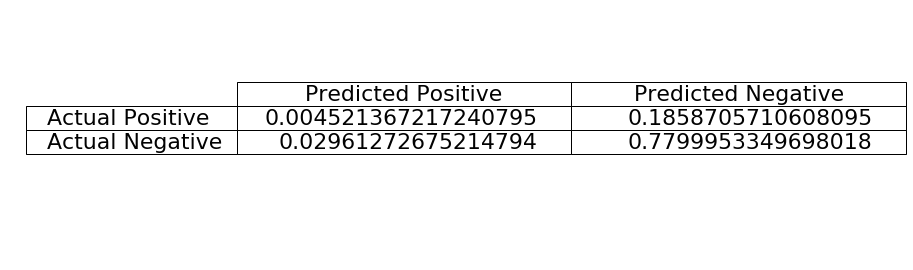

In [82]:
ConfusionMatrix.concat(iterator=adaboost_cm.values()).plot()

ConnectionStrengthClassifier(base_estimator=DecisionTreeClassifier(class_weight={False: 1, True: 4}, criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
               base_strength=0.2, combined_weight=0.4, threshold=0.05)
Accuracy: 0.627163069204787


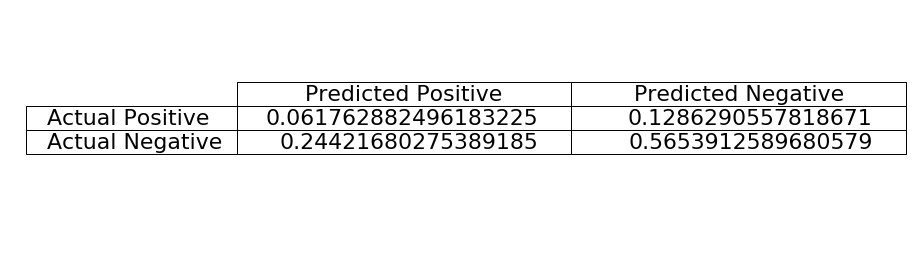

In [79]:
model = sklearn.tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_leaf=minimum_samples_leaf, class_weight={False:1, True: 4})
final_model = ConnectionStrengthClassifier(base_estimator=model, threshold=0.05, base_strength=0.2, combined_weight=0.4)
adaboost_cm = run_strength_model(final_model)
ConfusionMatrix.concat(iterator=adaboost_cm.values()).plot()